In [78]:
import pyddm.plot
from pyddm import Model, set_N_cpus
from pyddm.models import DriftConstant, DriftLinear, NoiseConstant,Bound,Drift, BoundConstant, OverlayNonDecision, ICPointSourceCenter,BoundCollapsingLinear
from pyddm.functions import fit_adjust_model, display_model

from pyddm import Fittable, Fitted, Sample
from pyddm.models import LossRobustBIC, LossBIC, LossLikelihood, LossRobustLikelihood,LossSquaredError
from pyddm.functions import fit_adjust_model


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import scipy
from statannot import add_stat_annotation
import glob

from sbi import utils
from scipy import stats

%matplotlib inline

<AxesSubplot:title={'center':'Drift-Diffusion Model'}>

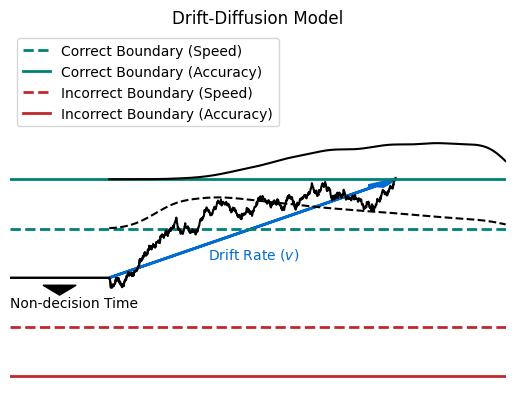

In [207]:
def DDM_SAT_plot(ax=None):
    if ax is None:
        ax = plt.gca()
    T_dur = 1.5
    
    ### speed condition
    model = Model(name='Simple model',
                  drift=DriftConstant(drift=1),
                  noise=NoiseConstant(noise=1),
                  bound=BoundConstant(B=1),
                  overlay=OverlayNonDecision(nondectime=.3),
                  dx=.001, dt=.001, T_dur=T_dur)
    sol = model.solve()
    samp = sol.resample(10000)
    samps = samp.to_pandas_dataframe(drop_undecided = True, choice_column_name='correct')

    evidence = model.simulate_trial(seed=1)
    t = np.arange(len(evidence))/1000
    t_kde = np.arange(300,T_dur*1000)/1000
    #print(samps)

    c_prop = sum(samps['correct']==1)/len(samps['correct'])
    i_prop = sum(samps['correct']==0)/len(samps['correct'])

    kde_c = stats.gaussian_kde(samps[samps['correct']==1]['RT'])(t_kde)*c_prop
    kde_i = stats.gaussian_kde(samps[samps['correct']==0]['RT'])(t_kde)*i_prop
    
    ax.plot(t,evidence, color = 'black')
    
    # drift rate
    #ax.arrow(x=0.3, y=0, dx=(t[-1]-0.3), dy=1, 
    #          head_width=0.05, head_length=0.15,
    #          color = '#006CD1',length_includes_head = True, linewidth = 2)
    ax.text(x=0.6, y=0.4, s = "Drift Rate ($v$)", color = '#006CD1')
    
    # boundaries
    boundary = 2
    line1 = ax.axhline(y = 1, color = '#008176',linewidth = 2, linestyle = 'dashed', label = "Correct Boundary (Speed)")
    #ax.text(x=-0.1, y=1.2, s = "Correct Boundary (Speed)", color = '#008176')
    ax.plot(t_kde,kde_c/2+1,color = "black" ,linestyle = 'dashed')
    #ax.text(x=1, y=1.8, s = "Correct RT Distribution",color = "#008176")

    line2 = ax.axhline(y = -1, color = '#c1272d',linewidth = 2, linestyle = 'dashed', label = "Incorrect Boundary (Speed)")
    #ax.text(x=-0.1, y=-1.26, s = "Incorrect Boundary (Speed)", color = '#c1272d')
    #ax.plot(t_kde,-kde_i-1,color = "black")#,linestyle = 'dashed')
    #ax.text(x=1, y=-1.8, s = "Incorrect RT Distribution",color = "#c1272d")
    
    ### accuracy condition
    model = Model(name='Simple model',
                  drift=DriftConstant(drift=1),
                  noise=NoiseConstant(noise=1),
                  bound=BoundConstant(B=2),
                  overlay=OverlayNonDecision(nondectime=.3),
                  dx=.001, dt=.001, T_dur=T_dur)
    sol = model.solve()
    samp = sol.resample(10000)
    samps = samp.to_pandas_dataframe(drop_undecided = True, choice_column_name='correct')

    evidence = model.simulate_trial(seed=1)
    t = np.arange(len(evidence))/1000
    t_kde = np.arange(300,T_dur*1000)/1000
    
    c_prop = sum(samps['correct']==1)/len(samps['correct'])
    i_prop = sum(samps['correct']==0)/len(samps['correct'])

    kde_c = stats.gaussian_kde(samps[samps['correct']==1]['RT'])(t_kde)*c_prop
    kde_i = stats.gaussian_kde(samps[samps['correct']==0]['RT'])(t_kde)*i_prop
    
    ax.plot(t,evidence, color = 'black')
    
    # drift rate
    ax.arrow(x=0.3, y=0, dx=(t[-1]-0.3), dy=2, 
              head_width=0.05, head_length=0.15,
              color = '#006CD1',length_includes_head = True, linewidth = 2)
    #ax.text(x=0.3, y=0.6, s = "Drift Rate", color = '#006CD1')

    # boundaries
    line3 = ax.axhline(y = 2, color = '#008176',linewidth = 2, label = "Correct Boundary (Accuracy)")
    #ax.text(x=-0.1, y=2.2, s = "Correct Boundary (Accuracy)", color = '#008176')
    ax.plot(t_kde,kde_c/2+2,color = "black")#,linestyle = 'dotted')
    #ax.text(x=1, y=2.8, s = "Correct RT Distribution",color = "#008176")
    
    line4 = ax.axhline(y = -2, color = '#c1272d',linewidth = 2, label= "Incorrect Boundary (Accuracy)")
    #ax.text(x=-0.1, y=-2.26, s = "Incorrect Boundary (Accuracy)", color = '#c1272d')
    


    
    # plot limit
    ax.set_xlim(0,T_dur)
    ax.set_ylim(-2.5,5)
    ax.axis('off')
    ax.tick_params(left = False, bottom = False, labelleft = False, labelbottom = False)
    ax.set_title("Drift-Diffusion Model")

    # ndt
    ax.arrow(x=0.15, y=-0.15, dx=0, dy=-0.001, color = 'black',
              head_width=0.1, head_length=0.2)
    ax.text(x=0, y=-0.6, s = "Non-decision Time")
    ax.legend(handles=[line1, line3, line2, line4], loc = "upper left")

    return(ax)
DDM_SAT_plot()

In [135]:
model = Model(name='Simple model',
              drift=DriftLinear(drift=0.3,x = 10, t = 0),
              noise=NoiseConstant(noise=1),
              bound=BoundConstant(B=2),
              overlay=OverlayNonDecision(nondectime=.3),
              dx=.001, dt=.001, T_dur=3)
sol = model.solve()
#samp = sol.resample(10000)
#samps = samp.to_pandas_dataframe(drop_undecided = True)



In [137]:
evidence.shape

(524,)

In [ ]:
evidence_trials = np.array(())

In [136]:
for i in range(1000):
    evidence = model.simulate_trial(seed=i)


array([-2.20268248e-13, -2.20268248e-13, -2.20268248e-13, -2.20268248e-13,
       -2.20268248e-13, -2.20268248e-13, -2.20268248e-13, -2.20268248e-13,
       -2.20268248e-13, -2.20268248e-13, -2.20268248e-13, -2.20268248e-13,
       -2.20268248e-13, -2.20268248e-13, -2.20268248e-13, -2.20268248e-13,
       -2.20268248e-13, -2.20268248e-13, -2.20268248e-13, -2.20268248e-13,
       -2.20268248e-13, -2.20268248e-13, -2.20268248e-13, -2.20268248e-13,
       -2.20268248e-13, -2.20268248e-13, -2.20268248e-13, -2.20268248e-13,
       -2.20268248e-13, -2.20268248e-13, -2.20268248e-13, -2.20268248e-13,
       -2.20268248e-13, -2.20268248e-13, -2.20268248e-13, -2.20268248e-13,
       -2.20268248e-13, -2.20268248e-13, -2.20268248e-13, -2.20268248e-13,
       -2.20268248e-13, -2.20268248e-13, -2.20268248e-13, -2.20268248e-13,
       -2.20268248e-13, -2.20268248e-13, -2.20268248e-13, -2.20268248e-13,
       -2.20268248e-13, -2.20268248e-13, -2.20268248e-13, -2.20268248e-13,
       -2.20268248e-13, -

<AxesSubplot:title={'center':'Ornstein-Uhlenbeck Model'}>

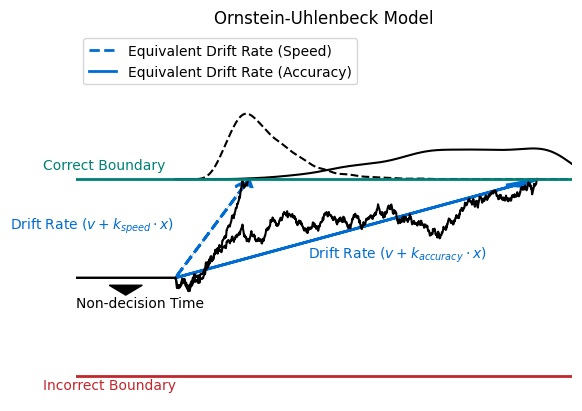

In [225]:
def OUM_SAT_plot(ax=None):
    if ax is None:
        ax = plt.gca()
    T_dur = 1.5
    ## speed
    model = Model(name='Simple model',
                  drift=DriftLinear(drift=0.3,x = 10, t = 0),
                  noise=NoiseConstant(noise=1),
                  bound=BoundConstant(B=2),
                  overlay=OverlayNonDecision(nondectime=.3),
                  dx=.001, dt=.001, T_dur=T_dur)
    sol = model.solve()
    samp = sol.resample(10000)
    samps = samp.to_pandas_dataframe(drop_undecided = True, choice_column_name='correct')

    evidence = model.simulate_trial(seed=1)
    t = np.arange(len(evidence))/1000
    t_kde = np.arange(300,T_dur*1000)/1000

    c_prop = sum(samps['correct']==1)/len(samps['correct'])
    i_prop = sum(samps['correct']==0)/len(samps['correct'])

    kde_c = stats.gaussian_kde(samps[samps['correct']==1]['RT'])(t_kde)*c_prop
    kde_i = stats.gaussian_kde(samps[samps['correct']==0]['RT'])(t_kde)*i_prop
    
    ax.plot(t,evidence, color = 'black')
    
    ax.plot(t_kde,kde_c/2+2,color = "black",linestyle = 'dashed')
    #ax.text(x=1, y=2.8, s = "Correct RT Distribution",color = "#008176")
    
    # drift rate
    line1 = ax.arrow(x=0.3, y=0, dx=(t[-1]-0.3), dy=2, 
              head_width=0.05, head_length=0.15,
              color = '#006CD1',length_includes_head = True,linestyle = 'dashed', linewidth = 2, label = "Speed")
    
    ## accuracy
    model = Model(name='Simple model',
                  drift=DriftLinear(drift=0.3,x = 0, t = 0),
                  noise=NoiseConstant(noise=1),
                  bound=BoundConstant(B=2),
                  overlay=OverlayNonDecision(nondectime=.3),
                  dx=.001, dt=.001, T_dur=T_dur)
    sol = model.solve()
    samp = sol.resample(10000)
    samps = samp.to_pandas_dataframe(drop_undecided = True, choice_column_name='correct')

    evidence = model.simulate_trial(seed=1)
    t = np.arange(len(evidence))/1000
    t_kde = np.arange(300,T_dur*1000)/1000

    c_prop = sum(samps['correct']==1)/len(samps['correct'])
    i_prop = sum(samps['correct']==0)/len(samps['correct'])

    kde_c = stats.gaussian_kde(samps[samps['correct']==1]['RT'])(t_kde)*c_prop
    kde_i = stats.gaussian_kde(samps[samps['correct']==0]['RT'])(t_kde)*i_prop
    
    ax.plot(t,evidence, color = 'black')
    
    ax.plot(t_kde,kde_c/2+2,color = "black")#,linestyle = 'dotted')
    #ax.text(x=1, y=2.8, s = "Correct RT Distribution",color = "#008176")
    
    # drift rate
    line2 = ax.arrow(x=0.3, y=0, dx=(t[-1]-0.3), dy=2, 
              head_width=0.05, head_length=0.15,
              color = '#006CD1',length_includes_head = True, linewidth = 2, label = "Accuracy")
    #ax.text(x=0.3, y=0.6, s = "Drift Rate", color = '#006CD1')
    

    # boundaries
    ax.axhline(y = 2, color = '#008176',linewidth = 2)
    ax.text(x=-0.1, y=2.2, s = "Correct Boundary", color = '#008176')

    ax.axhline(y = -2, color = '#c1272d',linewidth = 2)
    ax.text(x=-0.1, y=-2.26, s = "Incorrect Boundary", color = '#c1272d')
    #ax.plot(t_kde,-kde_i-2,color = "black")#,linestyle = 'dashed')
    #ax.text(x=1, y=-2.8, s = "Incorrect RT Distribution",color = "#c1272d")
    
    # plot limit
    ax.set_xlim(0,T_dur)
    ax.set_ylim(-2.5,5)
    ax.axis('off')
    ax.tick_params(left = False, bottom = False, labelleft = False, labelbottom = False)
    ax.set_title("Ornstein-Uhlenbeck Model")


    # ndt
    ax.arrow(x=0.15, y=-0.15, dx=0, dy=-0.001, color = 'black',
              head_width=0.1, head_length=0.2)
    ax.text(x=0, y=-0.6, s = "Non-decision Time")
    
    # leakage or self-excitation
    #ax.arrow(x=0.2, y=0.2, dx=0, dy=1.2, head_width=0.05, head_length=0.15, 
    #         color = '#994F00',linestyle = 'dashed', linewidth = 2)    
    ax.text(x=-0.2, y=1, s = "Drift Rate ($v + k_{speed}\cdot x$)", color = '#006CD1')
    
    #ax.arrow(x=1, y=0.1, dx=0, dy=0.6, head_width=0.05, head_length=0.15, color = '#994F00', linewidth = 2)    
    ax.text(x=0.7, y=0.4, s = "Drift Rate ($v + k_{accuracy}\cdot x$)", color = '#006CD1')
    

    
    # legend
    line1 = ax.axhline(y = 200, color = '#006CD1',linewidth = 2, linestyle = 'dashed',label = "Equivalent Drift Rate (Speed)")
    line2 = ax.axhline(y = 200, color = '#006CD1',linewidth = 2, label = "Equivalent Drift Rate (Accuracy)")
    #line3 = ax.axhline(y = 200, color = '#994F00',linewidth = 2, linestyle = 'dashed',label = "Self-excitation (Speed)")
    #line4 = ax.axhline(y = 200, color = '#994F00',linewidth = 2, label = "Self-excitation (Accuracy)")

    ax.legend(handles=[line1, line2], loc = "upper left")

    return(ax)
OUM_SAT_plot()

<AxesSubplot:title={'center':'Ornstein-Uhlenbeck Model'}>

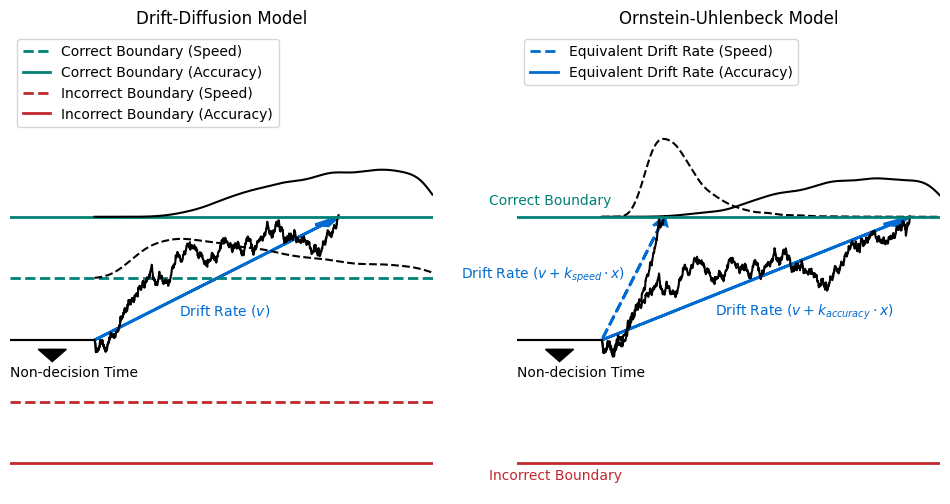

In [223]:
fig, axes = plt.subplots(1,2,figsize=(12, 6))
DDM_SAT_plot(ax=axes[0])
OUM_SAT_plot(ax=axes[1])

<Axes: title={'center': 'RT Distributions'}>

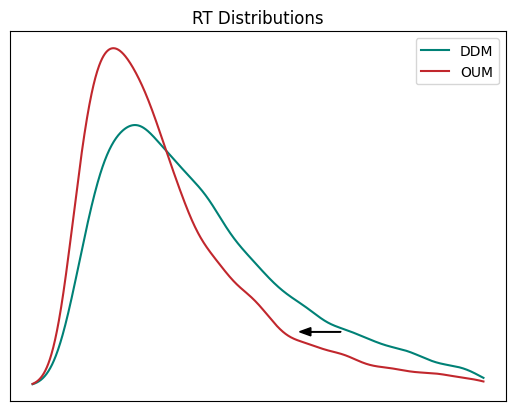

In [67]:
def SAT_plot(ax=None):
    if ax is None:
        ax = plt.gca()
    T_dur = 1.5
    
    ### DDM
    model = Model(name='Simple model',
                  drift=DriftConstant(drift=2),
                  noise=NoiseConstant(noise=1),
                  bound=BoundConstant(B=1),
                  overlay=OverlayNonDecision(nondectime=.3),
                  dx=.001, dt=.001, T_dur=T_dur)
    sol = model.solve()
    samp = sol.resample(10000)
    samps = samp.to_pandas_dataframe(drop_undecided = True, choice_column_name='correct')

    evidence = model.simulate_trial(seed=1)
    t = np.arange(len(evidence))/1000
    t_kde = np.arange(300,T_dur*1000)/1000
    #print(samps)

    c_prop = sum(samps['correct']==1)/len(samps['correct'])
    i_prop = sum(samps['correct']==0)/len(samps['correct'])

    kde_c = stats.gaussian_kde(samps[samps['correct']==1]['RT'])(t_kde)*c_prop
    kde_i = stats.gaussian_kde(samps[samps['correct']==0]['RT'])(t_kde)*i_prop
    line1 = ax.plot(t_kde,kde_c/2+1, color = '#008176', label = "DDM")

    ### OUM
    model = Model(name='Simple model',
                  drift=DriftLinear(drift=2,x = 2, t = 0),
                  noise=NoiseConstant(noise=1),
                  bound=BoundConstant(B=1),
                  overlay=OverlayNonDecision(nondectime=.3),
                  dx=.001, dt=.001, T_dur=T_dur)
    sol = model.solve()
    samp = sol.resample(10000)
    samps = samp.to_pandas_dataframe(drop_undecided = True, choice_column_name='correct')

    evidence = model.simulate_trial(seed=1)
    t = np.arange(len(evidence))/1000
    t_kde = np.arange(300,T_dur*1000)/1000
    #print(samps)

    c_prop = sum(samps['correct']==1)/len(samps['correct'])
    i_prop = sum(samps['correct']==0)/len(samps['correct'])

    kde_c = stats.gaussian_kde(samps[samps['correct']==1]['RT'])(t_kde)*c_prop
    kde_i = stats.gaussian_kde(samps[samps['correct']==0]['RT'])(t_kde)*i_prop
    line2 = ax.plot(t_kde,kde_c/2+1, color = '#c1272d', label = "OUM")
    
    # ndt
    ax.arrow(x=1.12, y=1.2, dx=-0.08, dy=0, color = 'black',
              head_width=0.03, head_length=0.03)
    #ax.text(x=0, y=-0.6, s = "Non-decision Time")
    
    # plot limit
    #ax.axis('off')
    ax.tick_params(left = False, bottom = False, labelleft = False, labelbottom = False)
    #ax.set_title("Drift-Diffusion Model")
    ax.legend()
    ax.set_title("RT Distributions")


    return(ax)
SAT_plot()

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(12, 6))
DDM_SAT_plot(ax=axes[0])
OUM_SAT_plot(ax=axes[1])

In [168]:
def DDMc_SAT_plot(ax=None):
    if ax is None:
        ax = plt.gca()
    T_dur = 1.5
    
    ### speed condition
    model = Model(name='Simple model',
                  drift=DriftConstant(drift=1),
                  noise=NoiseConstant(noise=1),
                  bound=BoundCollapsingLinear(B=2,t = 1.5),
                  overlay=OverlayNonDecision(nondectime=.3),
                  dx=.001, dt=.001, T_dur=T_dur)
    sol = model.solve()
    samp = sol.resample(10000)
    samps = samp.to_pandas_dataframe(drop_undecided = True, choice_column_name='correct')

    #evidence = model.simulate_trial(seed=1)
    #t = np.arange(len(evidence))/1000
    #ax.plot(t,evidence, color = 'black')

    t_kde = np.arange(300,T_dur*1000)/1000
    #print(samps)

    c_prop = sum(samps['correct']==1)/len(samps['correct'])
    i_prop = sum(samps['correct']==0)/len(samps['correct'])

    kde_c = stats.gaussian_kde(samps[samps['correct']==1]['RT'])(t_kde)*c_prop
    kde_i = stats.gaussian_kde(samps[samps['correct']==0]['RT'])(t_kde)*i_prop
    
    
    # drift rate
    #ax.arrow(x=0.3, y=0, dx=(t[-1]-0.3), dy=1, 
    #          head_width=0.05, head_length=0.15,
    #          color = '#006CD1',length_includes_head = True, linewidth = 2)
    ax.text(x=0.6, y=0.4, s = "Drift Rate ($v$)", color = '#006CD1')
    
    # boundaries
    boundary = 2
    line1 = ax.plot(np.arange(0.3,1.5,0.001), -1.5*np.arange(0.3,1.5,0.001)+2.45,
              color = '#008176',linewidth = 2, linestyle = 'dashed')#, label = "Correct Boundary (Speed)")

    ax.plot(t_kde,kde_c/2+2,color = "black" ,linestyle = 'dashed')

    line2 = ax.plot(np.arange(0.3,1.5,0.001), 1.5*np.arange(0.3,1.5,0.001)-2.45,
              color = '#c1272d',linewidth = 2, linestyle = 'dashed')#, label = "Correct Boundary (Speed)")
    #ax.text(x=-0.1, y=-1.26, s = "Incorrect Boundary (Speed)", color = '#c1272d')
    #ax.plot(t_kde,-kde_i-1,color = "black")#,linestyle = 'dashed')
    #ax.text(x=1, y=-1.8, s = "Incorrect RT Distribution",color = "#c1272d")
    
    ### accuracy condition
    model = Model(name='Simple model',
                  drift=DriftConstant(drift=1),
                  noise=NoiseConstant(noise=1),
                  bound=BoundCollapsingLinear(B=2,t = 0.5),
                  overlay=OverlayNonDecision(nondectime=.3),
                  dx=.001, dt=.001, T_dur=T_dur)
    sol = model.solve()
    samp = sol.resample(10000)
    samps = samp.to_pandas_dataframe(drop_undecided = True, choice_column_name='correct')


    t_kde = np.arange(300,T_dur*1000)/1000
    
    c_prop = sum(samps['correct']==1)/len(samps['correct'])
    i_prop = sum(samps['correct']==0)/len(samps['correct'])

    kde_c = stats.gaussian_kde(samps[samps['correct']==1]['RT'])(t_kde)*c_prop
    kde_i = stats.gaussian_kde(samps[samps['correct']==0]['RT'])(t_kde)*i_prop
    
    evidence = model.simulate_trial(seed=1)
    t = np.arange(len(evidence))/1000    
    ax.plot(t,evidence, color = 'black')
    
    # drift rate
    ax.arrow(x=0.3, y=0, dx=(t[-1]-0.3), dy=evidence[-1], 
              head_width=0.05, head_length=0.15,
              color = '#006CD1',length_includes_head = True, linewidth = 2)

    # boundaries
    line3 = ax.axhline(y = 2, xmin=0, xmax=0.2, color = '#008176',linewidth = 2, label = "Correct Boundary (Accuracy)")
    #ax.text(x=-0.1, y=2.2, s = "Correct Boundary (Accuracy)", color = '#008176')
    ax.plot(t_kde,kde_c/2+2,color = "black")#,linestyle = 'dotted')
    
    line4 = ax.axhline(y = -2, xmin=0, xmax=0.2, color = '#c1272d',linewidth = 2, label= "Incorrect Boundary (Accuracy)")
    line5 = ax.plot(np.arange(0.3,1.5,0.001), -0.5*np.arange(0.3,1.5,0.001)+2.15,
              color = '#008176',linewidth = 2)#, label = "Correct Boundary (Speed)")    
    line6 = ax.plot(np.arange(0.3,1.5,0.001), 0.5*np.arange(0.3,1.5,0.001)-2.15,
              color = '#c1272d',linewidth = 2)#, label = "Correct Boundary (Speed)")
    
    # plot limit
    ax.set_xlim(0,T_dur)
    ax.set_ylim(-3,3)
    ax.axis('off')
    ax.tick_params(left = False, bottom = False, labelleft = False, labelbottom = False)
    ax.set_title("Drift-Diffusion Model with Linear Collapsing Boundary")

    # ndt
    ax.arrow(x=0.15, y=-0.15, dx=0, dy=-0.001, color = 'black',
              head_width=0.1, head_length=0.2)
    ax.text(x=0, y=-0.6, s = "Non-decision Time")
    #ax.legend(handles=[line1, line3, line2, line4], loc = "upper left")

    return(ax)


<Axes: title={'center': 'Drift-Diffusion Model with Linear Collapsing Boundary'}>

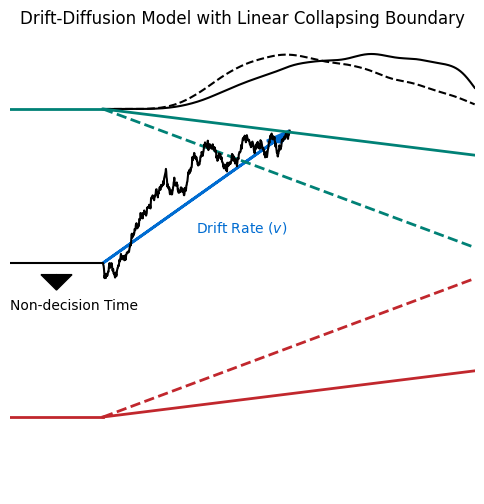

In [169]:
fig, axes = plt.subplots(figsize=(6, 6))
DDMc_SAT_plot(ax=axes)